**AUTHOR : ANAND VEERARAHAVAN**

###MOVIE REVIEW CLASSIFICATION

Import the libraries

In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module ='bs4')

In [4]:
lemmatizer = WordNetLemmatizer()
random.seed(1)
np.random.seed(1)

In [6]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name =fn, length = len(uploaded[fn])))

Saving train.tsv to train.tsv
User uploaded file "train.tsv" with length 8481022 bytes


In [7]:
train = pd.read_csv("train.tsv",sep='\t')
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name =fn, length = len(uploaded[fn])))

Saving test.tsv to test.tsv
User uploaded file "test.tsv" with length 3367149 bytes


In [9]:
test = pd.read_csv("test.tsv", sep="\t")
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [14]:
def clean_sentences(df):
  reviews = []

  for sent in tqdm(df['Phrase']):

    review_text = BeautifulSoup(sent).get_text()

    review_text = re.sub("[^a-zA-Z]"," ",review_text)

    words = word_tokenize(review_text.lower())

    omit_words = set(stopwords.words('english'))

    words = [x for x in words if x not in omit_words]

    lemma_words = [lemmatizer.lemmatize(i) for i in words]

    reviews.append(lemma_words)
  
  return reviews

train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

print(len(train_sentences))
print(len(test_sentences))



100%|██████████| 66292/66292 [00:43<00:00, 1521.92it/s]

156060
66292


In [15]:
target = train.Sentiment.values

num_features = 200

min_word_count = 5

num_workers = 1

context = 5

downsampling = 1e-3

In [16]:
from gensim.models import word2vec

model = word2vec.Word2Vec(train_sentences, workers = num_workers,\
                          size = num_features, min_count = min_word_count,\
                          window = context, sample = downsampling)
model.init_sims(replace = True)


In [17]:
model.wv.index2word[3]

'one'

In [18]:
print(model.wv.index2word[0], model.wv.index2word[1],model.wv.index2word[2],model.wv.index2word[3])

film movie n one


In [19]:
total_words = len(model.wv.vocab)
print(model.wv.index2word[total_words -1],model.wv.index2word[total_words -2],model.wv.index2word[total_words -3])

conceivable gracious hirosue


In [20]:
print(model.wv.most_similar('actor'))

[('lead', 0.900820791721344), ('jacobi', 0.9006929397583008), ('mcdormand', 0.8708429336547852), ('gawky', 0.865418016910553), ('dicaprio', 0.8643527030944824), ('role', 0.8621480464935303), ('hamming', 0.842282772064209), ('leery', 0.8348631858825684), ('niro', 0.8302038908004761), ('actress', 0.8160221576690674)]


In [21]:
def createFeatureVector(words, model, num_features):
  featVector = np.zeros((num_features,),dtype = "float32")

  nWords = 0

  index2word_set = set(model.wv.index2word)

  for word in words :
    if word in index2word_set:
      nWords = nWords + 1.
      featVector = np.add(featVector,model[word])
  
  if(nWords!=0):
    featVector = np.divide(featVector, nWords)
  return featVector

def avgFeatureVectors(sentences, model, num_features):
  overallFeatureVectors = []
  for sentence in tqdm(sentences):
    overallFeatureVectors.append(createFeatureVector(sentence, model, num_features))
  return overallFeatureVectors

train_vect = avgFeatureVectors(train_sentences, model, num_features)
test_vect = avgFeatureVectors(test_sentences,model, num_features)



  0%|          | 0/156060 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66292/66292 [01:22<00:00, 805.15it/s]


In [22]:
X_train,X_val,y_train,y_val = train_test_split(train_vect,target,test_size=0.2,stratify=target) 
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state =1, n_estimators = 500, verbose = 1, n_jobs = -1, oob_score = True)
model_rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=1,
                       warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

result = model_rf.predict(X_val)
score = accuracy_score(y_val,result)
print(score)
print(classification_report(y_val,result))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    4.6s


0.6234140715109573
              precision    recall  f1-score   support

           0       0.46      0.30      0.36      1414
           1       0.53      0.41      0.46      5455
           2       0.68      0.83      0.75     15916
           3       0.55      0.46      0.50      6586
           4       0.50      0.33      0.40      1841

    accuracy                           0.62     31212
   macro avg       0.54      0.46      0.49     31212
weighted avg       0.61      0.62      0.61     31212



[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    5.1s finished


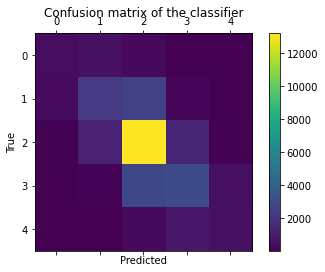

[[  427   593   359    34     1]
 [  404  2213  2608   225     5]
 [   88  1214 13179  1373    62]
 [    5   144  2866  3037   534]
 [    3    27   333   876   602]]


In [24]:
labels = [0,1,2,3,4]
conf = confusion_matrix(y_val,result,labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(conf)


**CONCLUSION**

From the above results , we can say that most of the reviews are nuetral.